In [1]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy import spatial
from sklearn.decomposition import PCA

from lightfm import LightFM
from lightfm.data import Dataset
from sklearn.mixture import GaussianMixture

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-swjgfsr_ because the default path (/home/i313924/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
THREADS = 8

## Preparing files

In [3]:
df = pd.read_csv('/pio/scratch/1/i313924/data/train_data/slim_ratings.csv',
                 names=['asin', 'reviewerID', 'overall', 'unixReviewTime'])
df = df.loc[(df['overall'] >= 4.0)]

In [4]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [5]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')

In [27]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/slim_interactions.npz')

## Extracting item embeddings

In [19]:
item_mapping = dataset.mapping()[2]

In [15]:
item_asins = df.asin.unique()

In [16]:
women_idxs = categories[(categories.category_1 == "Women") & (categories.asin.isin(item_asins))].asin.values
men_idxs = categories[(categories.category_1 == "Men") & (categories.asin.isin(item_asins))].asin.values

In [21]:
women_idxs = [item_mapping[idx] for idx in women_idxs]
men_idxs = [item_mapping[idx] for idx in men_idxs]

## Training

In [80]:
superepochs = 20

In [81]:
model = LightFM(no_components=100, learning_schedule='adadelta', loss='warp')

In [82]:
women_embeddings = np.zeros((superepochs*len(women_idxs), 100))
men_embeddings = np.zeros((superepochs*len(men_idxs), 100))
for i in tqdm(range(superepochs)):
    model.fit_partial(interactions, verbose=False, epochs=5, num_threads=THREADS)
    women_embeddings[i*len(women_idxs):(i+1)*len(women_idxs), :] = model.item_embeddings[women_idxs]
    men_embeddings[i*len(men_idxs):(i+1)*len(men_idxs), :] = model.item_embeddings[men_idxs]

  0%|          | 0/20 [00:00<?, ?it/s]

In [83]:
embeddings = np.append(women_embeddings, men_embeddings, axis = 0)

In [84]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [85]:
transformed_women_embeddings = pca.transform(women_embeddings)
transformed_men_embeddings = pca.transform(men_embeddings)

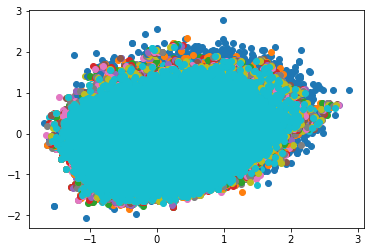

In [86]:
women_means = []
for i in range(superepochs):
    plt.scatter(transformed_women_embeddings[i*len(women_idxs):(i+1)*len(women_idxs), 0], transformed_women_embeddings[i*len(women_idxs):(i+1)*len(women_idxs), 1])
    gm = GaussianMixture(n_components=1, random_state=0).fit(transformed_women_embeddings[i*len(women_idxs):(i+1)*len(women_idxs), :])
    women_means.append(gm.means_[0])

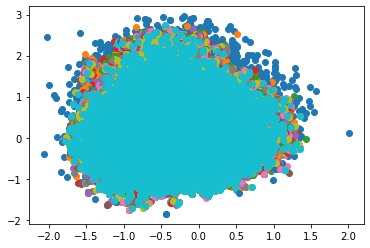

In [87]:
men_means = []
for i in range(superepochs):
    plt.scatter(transformed_men_embeddings[i*len(men_idxs):(i+1)*len(men_idxs), 0], transformed_men_embeddings[i*len(men_idxs):(i+1)*len(men_idxs), 1])
    gm = GaussianMixture(n_components=1, random_state=0).fit(transformed_men_embeddings[i*len(men_idxs):(i+1)*len(men_idxs), :])
    men_means.append(gm.means_[0])

In [88]:
men_means = np.array(men_means)
women_means = np.array(women_means)

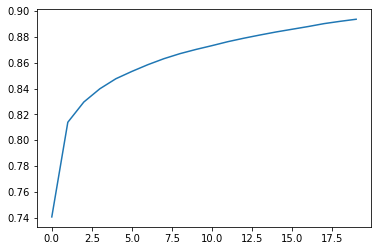

In [89]:
plt.plot(np.sqrt(((men_means - women_means)**2).sum(axis=1)))